In [1]:
colab = True
if colab:
    import sys
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    sys.path.append('drive/My Drive/Colab Notebooks/Income_prediction')
    prefix = 'drive/My Drive/Colab Notebooks/Income_prediction/'
else:
    prefix = ''

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import time
from sklearn import model_selection
from sklearn import preprocessing
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from scipy.stats import mode
from imblearn.over_sampling import SMOTE
import preprocess
import model
import joblib
import warnings


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip i

# Preprocessing

### Get raw data

In [3]:
def get_data(url):
    print('Start getting data...')
    start = time.time()
    columns = ['age',
    'class of worker',
    'detailed industry recode',
    'detailed occupation recode',
    'education',
    'wage per hour',
    'enroll in edu inst last wk',
    'marital status',
    'major industry code',
    'major occupation code',
    'race',
    'hispanic origin',
    'sex',
    'member of a labor union',
    'reason for unemployment',
    'full or part time employment stat',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'tax filer stat',
    'region of previous residence',
    'state of previous residence',
    'detailed household and family stat',
    'detailed household summary in household',
    'instance weight',
    'migration code-change in msa',
    'migration code-change in reg',
    'migration code-move within reg',
    'live in this house 1 year ago',
    'migration prev res in sunbelt',
    'num persons worked for employer',
    'family members under 18',
    'country of birth father',
    'country of birth mother',
    'country of birth self',
    'citizenship',
    'own business or self employed',
    'fill inc questionnaire for veterans admin',
    'veterans benefits',
    'weeks worked in year',
    'year',
    'class'
    ]
    data=pd.read_csv(url, names = columns, na_values=' ?')
    # data = data.head(1000) # For testing purpose!!!
    for col in data.select_dtypes('O').columns:
        data[col] = data[col].astype('category')
    print('Done getting data. Time taken = {:.1f}(s) \n'.format(time.time()-start))
    return data
    
# Get data
url = prefix+'census/census-income.data'
raw_data = get_data(url)

Start getting data...
Done getting data. Time taken = 4.2(s) 



### EDA

In [6]:
pd.options.display.max_columns = None
raw_data.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veterans admin,veterans benefits,weeks worked in year,year,class
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
age                                          199523 non-null int64
class of worker                              199523 non-null category
detailed industry recode                     199523 non-null int64
detailed occupation recode                   199523 non-null int64
education                                    199523 non-null category
wage per hour                                199523 non-null int64
enroll in edu inst last wk                   199523 non-null category
marital status                               199523 non-null category
major industry code                          199523 non-null category
major occupation code                        199523 non-null category
race                                         199523 non-null category
hispanic origin                              199523 non-null category
sex                                          199523 non-null 

In [8]:
raw_data.groupby('class').count()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veterans admin,veterans benefits,weeks worked in year,year
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
- 50000.,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,186478,187141,187141,187141,93988,93988,93988,187141,93988,187141,187141,180977,181491,184045,187141,187141,187141,187141,187141,187141
50000+.,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,12337,12382,12382,12382,5839,5839,5839,12382,5839,12382,12382,11833,11913,12085,12382,12382,12382,12382,12382,12382


##### Imbalanced dataset => Need to decide weather we should go for re-sampling techniques or not (after performance evaluation)

### Outlier detection 

In [9]:
raw_data.describe()

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,instance weight,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


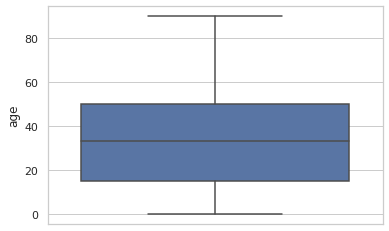

In [10]:
sns.set(style="whitegrid")
ax = sns.boxplot(y=raw_data['age'])

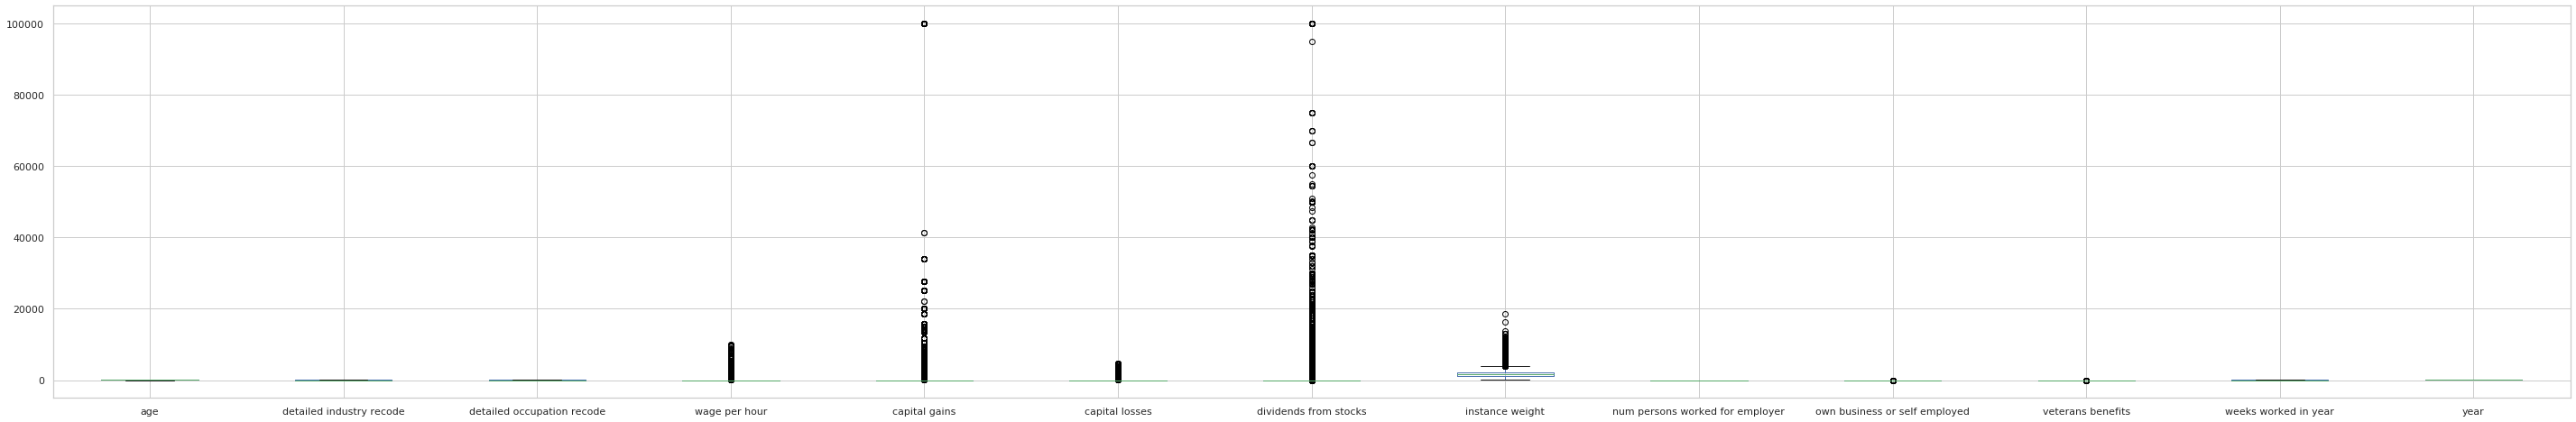

In [11]:
raw_data.select_dtypes(exclude = 'O').plot(kind = 'box', figsize = (50,8))

### Find missing values

In [0]:
contain_null = np.array(raw_data.isnull().sum().to_frame()[raw_data.isnull().sum().to_frame()[0]!=0].index)

There are 8 features having missing values: 
- state of previous residence
- migration code-change in msa 
- migration code-change in reg 
- migration code-move within reg
- migration prev res in sunbelt 
- country of birth father
- country of birth mother
- country of birth self


**Model development**

In [0]:
def preprocess_data(url, seed):
    preprocessor = preprocess.Preprocessor()
    raw_data = preprocessor.get_data(url)
    contain_null = preprocessor.get_null(raw_data)
    for f in contain_null:
        raw_data.loc[(raw_data[f].isnull()),f] = preprocessor.ImputeVoteClassifier(raw_data, f)
    X_train, y_train, X_test, y_test = preprocessor.split_data(raw_data, seed, re=False)
    return X_train, y_train, X_test, y_test
def build_model(X_train, y_train, X_test, y_test, n_fold, seed):
    modeler = model.Model()
    clf_list = [modeler.clf_0, modeler.clf_2]
    oof_train = []
    oof_test = []
    for clf in clf_list:
        clf_oof_train, clf_oof_test = modeler.generate_oof(clf, X_train, y_train, X_test, n_fold, seed)
        oof_train.append(pd.DataFrame(clf_oof_train))
        oof_test.append(pd.DataFrame(clf_oof_test))
    meta_train = modeler.generate_metadata(oof_train)
    meta_test = modeler.generate_metadata(oof_test)
    # Fit Meta classifier
    meta_clf = modeler.model_predict(modeler.clf_3, meta_train, y_train, meta_test, y_test, seed)
    print('Start dumping Meta classifier...')
    joblib.dump(meta_clf, 'meta_clf.pkl') 
    print('Done dumping Meta classifier ! \n')
    return meta_clf
if __name__=='__main__':
    print('*'*100) 
    print('*'*100+'\n')
    seed = 1003
    n_fold = 5
    colab = False
    url = prefix+'census/census-income.data'
    X_train, y_train, X_test, y_test = preprocess_data(url, seed)
    meta_clf = build_model(X_train, y_train, X_test, y_test, n_fold, seed)
    